In [0]:
import numpy as np
import sys, os, pickle, time

import tensorflow.compat.v2 as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Flatten, Dense, Conv2D, MaxPool2D,
                                GlobalAveragePooling2D, Activation, BatchNormalization,
                                Dropout, GRU, Bidirectional, Reshape, Lambda)
from tensorflow.keras import backend as K
import sys, os, pickle, time

In [2]:
!git clone https://github.com/marcelosena/cs230
!unzip cs230/CS230OCR/ProcessedData/KerasReady0.zip -d cs230/CS230OCR/ProcessedData/
sys.path.append('/content/cs230/CS230OCR/NeuralNet')

Cloning into 'cs230'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 73 (delta 15), reused 58 (delta 11), pack-reused 0
Unpacking objects: 100% (73/73), done.
Archive:  cs230/CS230OCR/ProcessedData/KerasReady0.zip
  inflating: cs230/CS230OCR/ProcessedData/KerasReady0.npy  


In [3]:
path = '/content/cs230/CS230OCR/'
from utils.inputFinland import loadImgsWithLabels, DataGen
from utils.BasicConfig import (BATCH_SIZE, FULLCHARDICT,  INPUTSHAPE, LOGDIR, SAVEDIR)
from utils.Callbacks import VizCallback
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
  logical_gpus = tf.config.experimental.list_logical_devices('GPU')
  print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


Downloading the large keras dataset through google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!unzip 'gdrive/My Drive/CS230/Keras_largeData/KerasReadyFull0.zip' -d cs230/CS230OCR/ProcessedData/

Archive:  gdrive/My Drive/CS230/Keras_largeData/KerasReadyFull0.zip
  inflating: cs230/CS230OCR/ProcessedData/KerasReadyFull0.npy  


Data Parameters

In [0]:
BATCH_SIZE = 32
IMGWIDTH = 128
IMGHEIGHT = 64
CHANNELS = 1
INPUTSHAPE =  [IMGWIDTH,IMGHEIGHT,1]
FULLCHARDICT = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'/':10,',':11, '+': 12, '-': 13, ' ': 14}
CHARDICT = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'/':10,',':11, '+': 12, '-': 13,}
INVDICT = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '/', 11: ',', 12: '+', 13: '-'}
DICTLENGTH = len(CHARDICT) + 1 # for the empty string
MAXCHARLENGTH = 6

Preparing Finish Dataset

In [0]:
X, Y_label, Y_len,  N = loadImgsWithLabels(True)
randomOrder = pickle.load(open(path + f'ProcessedData/orderFull.p', 'rb'))
X = X[randomOrder]
Y_label = Y_label[randomOrder]
Y_len = Y_len[randomOrder]

trainID = int(np.ceil(N*0.33))
devID = trainID + int(np.ceil((N - trainID)/2))

X_train = X[:trainID]
Y_label_train = Y_label[:trainID]
Y_len_train = Y_len[:trainID]

X_dev = X[trainID:devID]
Y_label_dev = Y_label[trainID:devID]
Y_len_dev = Y_len[trainID:devID]

X_test = X[devID:]
Y_label_test = Y_label[devID:]
Y_len_test = Y_len[devID:]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_label_train)).batch(BATCH_SIZE)
dev_dataset = tf.data.Dataset.from_tensor_slices((X_dev, Y_label_dev)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_label_test)).batch(BATCH_SIZE)

Sample Data

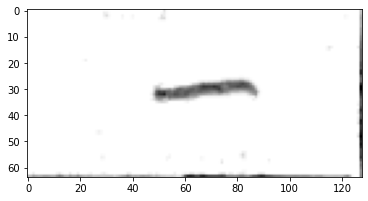

[13. -1. -1. -1. -1. -1.]


In [8]:
from matplotlib import pyplot as plt

indexShow = 834
plt.imshow(X_test[indexShow,:,:,0].T, cmap='Greys')
plt.show()
print(Y_label_test[indexShow])

Transfer Models Specifications

In [9]:
INPUTSHAPE_CHAN3 =  [IMGWIDTH,IMGHEIGHT,3]
X_train_CHAN3 = np.repeat(X_train, 3, -1)

print("###########################")
print("########## VGG19 ##########")
print("###########################")

base_model_vgg = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape= INPUTSHAPE_CHAN3,
    include_top=False)
base_model_vgg.trainable = False
base_model_vgg.summary()

print("\n")
print("\n")
print("\n")
print("############################")
print("######### ResNet50 #########")
print("############################")

base_model_resNet = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape= INPUTSHAPE_CHAN3,
    include_top=False)
base_model_resNet.trainable = False
base_model_resNet.summary()

###########################
########## VGG19 ##########
###########################
80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 64, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 64, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 32, 

Loss Function

In [0]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Keras Model Specifiation - Transfer Learning from VGG19

In [11]:
# Layer params:   Filts K  Padding  Name
layer_params = [ [  64, 7, 'same',  'conv1'],
                 [  64, 5, 'same',  'conv2'],
                 [ 128, 3, 'same',  'conv3'],
                 [ 128, 3, 'same',  'conv4'],
                 [ 256, 3, 'same',  'conv5'],
                 [ 256, 3, 'same',  'conv6'],
                 ]
wherePool = [1,3,5]

# Network parameters
kernel_size = (3, 3)
pool_size = (2,2)
denseSize = 128
rnn_size = 256
act = 'relu'
minibatch_size = BATCH_SIZE
retrain = False

### Transfer-Learned Conv-NN ###
tiling = [1] * 4
tiling[-1] *= 3
inputs = Input(name='the_input', shape=INPUTSHAPE)
inner = keras.backend.tile(inputs, tiling)

# inner = base_model(inner)
base_model = base_model_vgg

# # full model
# inner = base_model(inner, training=False)

# # only the first conv-nn part
# l1 = base_model.layers[0]
# l2 = base_model.layers[1]
# l3 = base_model.layers[2]
# l4 = base_model.layers[3]
# l5 = base_model.layers[4]
# l1.set_weights = l1.get_weights()
# l2.set_weights = l2.get_weights()
# l3.set_weights = l3.get_weights()
# l4.set_weights = l4.get_weights()
# l5.set_weights = l5.get_weights()

# # # Setting layers to non-trainable
# l1.trainable = retrain
# l2.trainable = retrain
# l3.trainable = retrain
# l4.trainable = retrain
# l5.trainable = retrain
# inner = l1(inner)
# inner = l2(inner)
# inner = l3(inner)
# inner = l4(inner)
# inner = l5(inner)

print(len(base_model.layers))
### all conv-nn parts
for ll in range(len(base_model.layers) - 7):
  # if ll != 14 and ll != 17 and ll != 27 and ll != 37 and ll != 45 and ll != 49 and ll != 59 and ll != 69 and ll != 79 and ll != 87 and ll != 91 and ll != 101 and ll != 111:
    tmp_ll = base_model.layers[ll]
    tmp_ll.set_weights = base_model.layers[ll].get_weights()
    tmp_ll.trainable = retrain
    inner = tmp_ll(inner)

# ### Our Conv-NN ###
# inputs = Input(name='the_input', shape=INPUTSHAPE)
# layer = layer_params[0]
# inner = Conv2D(layer[0], layer[1], strides=(1,1), padding=layer[2], activation=act,
#                      use_bias=False, kernel_initializer="he_normal", name=layer[3] )(inputs)
# inner = BatchNormalization(momentum=0.95, epsilon=1e-05, center=True, scale=True)(inner)

# for i in range(1,len(layer_params)):
#     layer = layer_params[i]
#     inner = Conv2D(layer[0], layer[1], strides=(1,1), padding=layer[2], activation=act,
#                      use_bias=False, kernel_initializer="he_normal", name=layer[3] )(inner)
#     inner = BatchNormalization(momentum=0.95, epsilon=1e-05, center=True, scale=True)(inner)

#     if i in wherePool:
#        inner = MaxPool2D(pool_size=pool_size, strides=(2, 2), padding='same', name=f'pool{i+1}')(inner)

# conv_to_rnn_dims = ( IMGWIDTH// (pool_size[0] ** len(wherePool)) ,
#                     (IMGHEIGHT  // (pool_size[0] ** len(wherePool))) * layer_params[-1][0]
#                    )
# print(conv_to_rnn_dims)

inner = inner
trOutShape = inner.shape
conv_to_rnn_dims_transfer = (trOutShape[1], trOutShape[2]*trOutShape[3])
# print(trOutShape)
# print(conv_to_rnn_dims_transfer)

inner = Reshape(target_shape=conv_to_rnn_dims_transfer, name='reshape')(inner)
inner = Dense(denseSize, activation=act, name='dense1')(inner)
inner = BatchNormalization(momentum=0.95, epsilon=1e-05, center=True, scale=True)(inner)

# # Two layers of bidirectional GRUs
gru_1 = Bidirectional(GRU(rnn_size, return_sequences=True, recurrent_dropout=0.5, dropout=0.5,
            kernel_initializer='he_normal', name='gru1'), merge_mode='sum')(inner)
gru_2 = Bidirectional(GRU(rnn_size, return_sequences=True, recurrent_dropout=0.5, dropout=0.5,
            kernel_initializer='he_normal', name='gru2'))(gru_1)
y_pred = Dense(DICTLENGTH, kernel_initializer='he_normal', name='densePredict', activation='softmax')(gru_2)
print(y_pred)
print(y_pred.shape)
# keras.Model(inputs=inputs, outputs=y_pred).summary()

#%%
labels = Input(name='the_labels', shape=[MAXCHARLENGTH], dtype='float32')
input_length = Input(name='input_length',
                     shape=[1], #IMGWIDTH// (pool_size[0] ** len(wherePool)) - 2
                     dtype='int64')
label_length = Input(name='label_length',
                     shape=[1],
                     dtype='int64')
print(label_length)

#CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,),
    name='ctc')([y_pred, labels, input_length, label_length])

sgd = keras.optimizers.SGD(learning_rate=0.02,
          decay=1e-6,
          momentum=0.9,
          nesterov=True)
model = keras.Model(inputs=[inputs, labels, input_length, label_length],
              outputs=loss_out)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd, metrics=["accuracy"])

# test_func = K.function([inputs], [y_pred])
# model.summary()

22
Tensor("densePredict/Identity:0", shape=(None, 16, 15), dtype=float32)
(None, 16, 15)
Tensor("label_length:0", shape=(None, 1), dtype=int64)


Model Fitting

In [12]:
generatorTrain = DataGen(BATCH_SIZE,  (IMGWIDTH// (pool_size[0] ** len(wherePool))-2),
                    X_train, Y_label_train, Y_len_train,  len(X_train), 0)
generatorVal = DataGen(BATCH_SIZE,  (IMGWIDTH// (pool_size[0] ** len(wherePool))-2),
                    X_dev, Y_label_dev, Y_len_dev,  len(X_dev), 0)
generatorTest = DataGen(BATCH_SIZE,  (IMGWIDTH// (pool_size[0] ** len(wherePool))-2),
                    X_test, Y_label_test, Y_len_test,  len(X_test), 0)

#viz_cb = VizCallback(run_name, test_func, generatorVal.get_batch())
# early_stopping= keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='acc', baseline = 0.95, min_delta = 0.1, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint("bestRunning_model.hdf5",
                                            monitor='loss', verbose=1,
                                            save_best_only=True, mode='auto')

#%%
from tensorflow.keras.callbacks import EarlyStopping
usualCallback = EarlyStopping()
callCheck = [usualCallback, checkpoint]

history = model.fit(generatorTrain.get_batch(), epochs=5,
                       validation_data = generatorVal.get_batch(),
                    validation_steps = len(X_dev)//BATCH_SIZE,
                    steps_per_epoch = 20) #,
                    # callbacks = [usualCallback])
                    #callbacks=[viz_cb, early_stopping, checkpoint],)

Epoch 1/5
20/20 [==============================] - 18s 904ms/step - loss: 7.2382 - accuracy: 0.3375 - val_loss: 6.7142 - val_accuracy: 0.1850
Epoch 2/5
20/20 [==============================] - 17s 837ms/step - loss: 3.8312 - accuracy: 0.4656 - val_loss: 4.7698 - val_accuracy: 0.3292
Epoch 3/5
20/20 [==============================] - 16s 815ms/step - loss: 2.8068 - accuracy: 0.5906 - val_loss: 2.8508 - val_accuracy: 0.6784
Epoch 4/5
20/20 [==============================] - 16s 805ms/step - loss: 2.8688 - accuracy: 0.5609 - val_loss: 2.6560 - val_accuracy: 0.6813
Epoch 5/5
20/20 [==============================] - 17s 844ms/step - loss: 2.2756 - accuracy: 0.6453 - val_loss: 2.3548 - val_accuracy: 0.7046


Keras Model Specifiation - Transfer Learning from ResNet50

In [15]:
# Network parameters
kernel_size = (3, 3)
pool_size = (2,2)
denseSize = 128
rnn_size = 256
act = 'relu'
minibatch_size = BATCH_SIZE
retrain = False

### Transfer-Learned Conv-NN ###
tiling = [1] * 4
tiling[-1] *= 3
inputs = Input(name='the_input', shape=INPUTSHAPE)
inner = keras.backend.tile(inputs, tiling)

# inner = base_model(inner)
base_model = base_model_resNet

print(len(base_model.layers))
### all conv-nn parts
for ll in range(len(base_model.layers) - 120):
  if ll != 14 and ll != 17 and ll != 27 and ll != 37 and ll != 45 and ll != 49 and ll != 59 and ll != 69 and ll != 79 and ll != 87 and ll != 91 and ll != 101 and ll != 111:
    tmp_ll = base_model.layers[ll]
    tmp_ll.set_weights = base_model.layers[ll].get_weights()
    tmp_ll.trainable = retrain
    inner = tmp_ll(inner)

inner = inner
trOutShape = inner.shape
conv_to_rnn_dims_transfer = (trOutShape[1], trOutShape[2]*trOutShape[3])
inner = Reshape(target_shape=conv_to_rnn_dims_transfer, name='reshape')(inner)
inner = Dense(denseSize, activation=act, name='dense1')(inner)
inner = BatchNormalization(momentum=0.95, epsilon=1e-05, center=True, scale=True)(inner)

# # Two layers of bidirectional GRUs
gru_1 = Bidirectional(GRU(rnn_size, return_sequences=True, recurrent_dropout=0.5, dropout=0.5,
            kernel_initializer='he_normal', name='gru1'), merge_mode='sum')(inner)
gru_2 = Bidirectional(GRU(rnn_size, return_sequences=True, recurrent_dropout=0.5, dropout=0.5,
            kernel_initializer='he_normal', name='gru2'))(gru_1)
y_pred = Dense(DICTLENGTH, kernel_initializer='he_normal', name='densePredict', activation='softmax')(gru_2)

#%%
labels = Input(name='the_labels', shape=[MAXCHARLENGTH], dtype='float32')
input_length = Input(name='input_length',
                     shape=[1], #IMGWIDTH// (pool_size[0] ** len(wherePool)) - 2
                     dtype='int64')
label_length = Input(name='label_length',
                     shape=[1],
                     dtype='int64')

#CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,),
    name='ctc')([y_pred, labels, input_length, label_length])

sgd = keras.optimizers.SGD(learning_rate=0.02,
          decay=1e-6,
          momentum=0.9,
          nesterov=True)
model = keras.Model(inputs=[inputs, labels, input_length, label_length],
              outputs=loss_out)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd, metrics=["accuracy"])

## Fitting
generatorTrain = DataGen(BATCH_SIZE,  (IMGWIDTH// (pool_size[0] ** len(wherePool))-2),
                    X_train, Y_label_train, Y_len_train,  len(X_train), 0)
generatorVal = DataGen(BATCH_SIZE,  (IMGWIDTH// (pool_size[0] ** len(wherePool))-2),
                    X_dev, Y_label_dev, Y_len_dev,  len(X_dev), 0)
generatorTest = DataGen(BATCH_SIZE,  (IMGWIDTH// (pool_size[0] ** len(wherePool))-2),
                    X_test, Y_label_test, Y_len_test,  len(X_test), 0)

#viz_cb = VizCallback(run_name, test_func, generatorVal.get_batch())
# early_stopping= keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='acc', baseline = 0.95, min_delta = 0.001, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint("bestRunning_model.hdf5",
                                            monitor='loss', verbose=1,
                                            save_best_only=True, mode='auto')

#%%
from tensorflow.keras.callbacks import EarlyStopping
usualCallback = EarlyStopping()
callCheck = [usualCallback, checkpoint]

history = model.fit(generatorTrain.get_batch(), epochs=1,
                       validation_data = generatorVal.get_batch(),
                    validation_steps = len(X_dev)//BATCH_SIZE,
                    steps_per_epoch = 20) #,
                    # callbacks = [usualCallback])
                    #callbacks=[viz_cb, early_stopping, checkpoint],)

175
20/20 [==============================] - 15s 751ms/step - loss: 10.6639 - accuracy: 0.3422 - val_loss: 8.3044 - val_accuracy: 0.6944
